In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,f1_score, mean_squared_error,mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg,AR
import json
import arviz as az
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pymc3 as pm
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
import random
import theano.tensor as tt
import theano
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [2]:
df=pd.read_csv('/kaggle/input/new-data-climate-pop1/new_data_climate_pop.csv')
df


,date,state,elderly_mode,school_mode,unweighted_ili,mask,rr_av7,gp_av7,transit_av7,work_av7,resid_av7,ILIp,climate,spec.hum,Population,pca_1
0,2020-03-01,AL,0.0,0.0,6.325490,0.0000,12.857143,7.285714,10.285714,2.285714,-1.000000,0.006724,0.971477,0.006270,"5,031,362",38.286813
1,2020-03-01,AK,0.0,0.0,3.702840,0.0000,11.571429,8.142857,8.857143,3.571429,-0.857143,0.010216,0.966971,0.001963,"732,923",37.121842
2,2020-03-01,AZ,0.0,0.0,2.318160,0.0615,8.428571,6.000000,6.428571,2.571429,-1.000000,0.002891,0.777430,0.003478,"7,179,943",32.924371
3,2020-03-01,AR,0.0,0.0,4.901570,0.0000,17.142857,10.000000,5.857143,3.285714,-2.142857,0.021699,1.177655,0.004244,"3,014,195",37.846680
4,2020-03-01,CA,0.0,0.0,3.991470,0.1583,5.142857,5.000000,0.857143,2.428571,-0.714286,0.008007,0.793335,0.005577,"39,501,653",26.642818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5914,2022-06-26,VA,1.0,0.0,2.134940,0.1768,-8.571429,3.571429,-6.000000,-25.000000,4.428571,0.000098,-1.313860,0.013824,"8,683,619",7.431544
5915,2022-06-26,WA,2.0,1.0,1.660660,0.1681,-6.142857,1.714286,-15.000000,-30.000000,3.571429,0.000404,-1.316716,0.007892,"7,785,786",-0.332270
5916,2022-06-26,WV,2.0,0.0,0.479252,0.0980,0.285714,8.142857,32.000000,-17.571430,2.142857,0.000005,-1.348051,0.011811,"1,775,156",45.188274
5917,2022-06-26,WI,1.0,1.0,0.681439,0.0911,4.142857,13.571430,2.142857,-19.285710,1.714286,0.000041,-1.267011,0.010565,"5,892,539",24.297636


In [8]:
df=pd.read_csv('/kaggle/input/new-data-climate-pop1/new_data_climate_pop.csv')[['state','rr_av7','gp_av7','transit_av7','work_av7','elderly_mode','school_mode','mask','ILIp','pca_1','date','resid_av7','unweighted_ili']]
df['date']=pd.to_datetime(df['date'])
df1=(df.set_index('date',drop=True)).sort_values('state')
states=df1['state'].unique()
df1.sort_values(['state','date'],inplace=True)
lag_value=1
df1['school_mode'] = df1['school_mode'].round().astype('float')
df1['elderly_mode'] = df1['elderly_mode'].round().astype('float')
mapping = {0: 'no_policy', 1: 'low_policy', 2: 'med_policy', 3: 'high_policy'}
df1['elderly_mode'] = df1['elderly_mode'].astype(int).map(mapping)
df1['school_mode'] = df1['school_mode'].astype(int).map(mapping)

state_dfs = []

# List of unique states in your DataFrame
unique_states = df1['state'].unique()

# Loop through each state
for state in unique_states:
    # Filter the data for the current state
    state_df = df1[df1['state'] == state].copy()

    # Apply your operations to the state-specific DataFrame
    scaler = StandardScaler()
    state_df = state_df.dropna()
    state_df['school_mode_lag'] = state_df['school_mode']
    state_df['elderly_mode_lag'] = state_df['elderly_mode']
    state_df['school_mode_lag_temp'] = state_df['school_mode_lag']
    state_df['elderly_mode_lag_temp'] = state_df['elderly_mode_lag']
    state_df[['mask','pca_1','ILIp','resid_av7','unweighted_ili','rr_av7','gp_av7','transit_av7','work_av7']] = scaler.fit_transform(state_df[['mask','pca_1','ILIp','resid_av7','unweighted_ili','rr_av7','gp_av7','transit_av7','work_av7']])
    state_df['ILIp_lag'] = state_df['ILIp'].shift(1)
    state_df.sort_values(['state','date'], inplace=True, ascending=True)
    state_df = pd.get_dummies(state_df, columns=['school_mode_lag'], prefix='school_mode')
    state_df = pd.get_dummies(state_df, columns=['elderly_mode_lag'], prefix='elderly_mode')
    state_df['mask_lag'] = state_df['mask']
    state_df['resid_av7_lag'] = state_df['resid_av7']
    state_df['pca_1_lag'] = state_df['pca_1']

    state_df = state_df[:'2022-06-01'].dropna()
    
    # Append the state-specific DataFrame to the combined DataFrame
    state_dfs.append(state_df)

# Print the shape of the combined DataFrame and display the first few rows
combined_df = pd.concat(state_dfs[:])
combined_df1=combined_df.sort_values(['date','state'])
#state_mapping = {state: index for index, state in enumerate(unique_states, start=1)}
#combined_df1['state'] = combined_df1['state'].map(state_mapping)
combined_df1.head()

,state,rr_av7,gp_av7,transit_av7,work_av7,elderly_mode,school_mode,mask,ILIp,pca_1,...,school_mode_low_policy,school_mode_med_policy,school_mode_no_policy,elderly_mode_low_policy,elderly_mode_med_policy,elderly_mode_no_policy,mask_lag,resid_av7_lag,pca_1_lag,elderly_mode_high_policy
date,,,,,,,,,,,,,,,,,,,,,
2020-03-08,AK,0.436803,0.011297,0.130136,2.294141,no_policy,no_policy,-2.208069,-0.198821,0.308388,...,False,False,True,False,False,True,-2.208069,-1.286795,0.308388,NaN
2020-03-08,AL,2.096232,0.639062,0.954422,2.793303,no_policy,no_policy,-2.113635,6.449229,1.542047,...,False,False,True,False,False,True,-2.113635,-2.016313,1.542047,False
2020-03-08,AR,1.613665,1.067740,-0.030691,2.865827,no_policy,no_policy,-2.050976,3.714988,0.830706,...,False,False,True,False,False,True,-2.050976,-1.869136,0.830706,False
2020-03-08,AZ,2.745664,2.403388,2.519481,3.354103,no_policy,no_policy,-1.759342,3.973047,2.823112,...,False,False,True,False,False,True,-1.759342,-2.360187,2.823112,NaN
2020-03-08,CA,2.473677,2.896828,4.230679,4.168352,no_policy,no_policy,-2.329305,3.754572,3.709771,...,False,False,True,NaN,False,True,-2.329305,-1.929652,3.709771,False


In [15]:

formula = "ILIp	 ~ ILIp_lag+  C(school_mode_lag_temp, Treatment(reference='no_policy'))   + mask_lag + rr_av7 +transit_av7+gp_av7+work_av7 +resid_av7+ C(elderly_mode_lag_temp, Treatment(reference='low_policy'))   "
model = smf.mixedlm(formula, data=combined_df1,groups=combined_df1['state'])
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                        Mixed Linear Model Regression Results
======================================================================================================================
Model:                                  MixedLM                       Dependent Variable:                       ILIp  
No. Observations:                       5669                          Method:                                   REML  
No. Groups:                             50                            Scale:                                    0.1488
Min. group size:                        34                            Log-Likelihood:                           inf   
Max. group size:                        117                           Converged:                                Yes   
Mean group size:                        113.4                                                                         
----------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                                   0.000                                     
C(school_mode_lag_temp, Treatment(reference='no_policy'))[T.high_policy]   -0.018    0.026  -0.702 0.483 -0.070  0.033
C(school_mode_lag_temp, Treatment(reference='no_policy'))[T.low_policy]    -0.052    0.019  -2.700 0.007 -0.090 -0.014
C(school_mode_lag_temp, Treatment(reference='no_policy'))[T.med_policy]    -0.119    0.024  -5.041 0.000 -0.165 -0.073
C(elderly_mode_lag_temp, Treatment(reference='low_policy'))[T.high_policy] -0.007    0.022  -0.341 0.733 -0.050  0.035
C(elderly_mode_lag_temp, Treatment(reference='low_policy'))[T.med_policy]  -0.019    0.016  -1.186 0.236 -0.049  0.012
C(elderly_mode_lag_temp, Treatment(reference='low_policy'))[T.no_policy]    0.384    0.066   5.827 0.000  0.255  0.513
ILIp_lag                                                                    0.597    0.008  76.516 0.000  0.581  0.612
mask_lag                                                                   -0.068    0.008  -8.215 0.000 -0.084 -0.052
rr_av7                                                                      0.215    0.022   9.938 0.000  0.173  0.258
transit_av7                                                                -0.060    0.014  -4.133 0.000 -0.088 -0.031
gp_av7                                                                     -0.166    0.011 -15.592 0.000 -0.187 -0.145
work_av7                                                                    0.035    0.011   3.235 0.001  0.014  0.056
resid_av7                                                                   0.008    0.020   0.406 0.685 -0.031  0.048
Group Var                                                                   0.000                                     
======================================================================================================================

"""

In [16]:
combined_df1[['rr_av7','transit_av7','gp_av7','work_av7','resid_av7']].corr()

,rr_av7,transit_av7,gp_av7,work_av7,resid_av7
rr_av7,1.000000,0.907073,0.811474,0.652054,-0.923853
transit_av7,0.907073,1.000000,0.785057,0.549542,-0.855105
gp_av7,0.811474,0.785057,1.000000,0.377483,-0.665599
work_av7,0.652054,0.549542,0.377483,1.000000,-0.796229
resid_av7,-0.923853,-0.855105,-0.665599,-0.796229,1.000000


In [18]:
#random_effects = result.random_effects
r_squared_values = [score for _, score in r2_scores]
mean_r2_score = sum(r_squared_values) / len(r_squared_values)
mean_r2_score

0.631467929756816

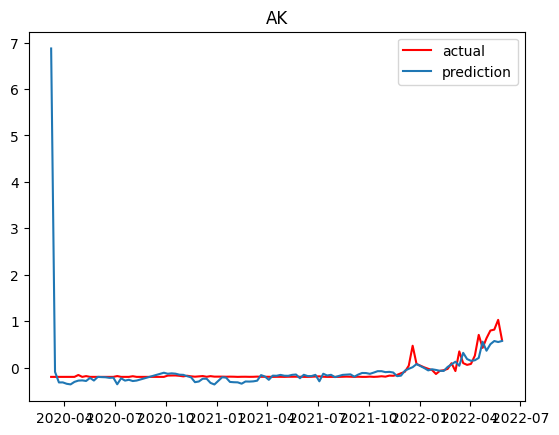

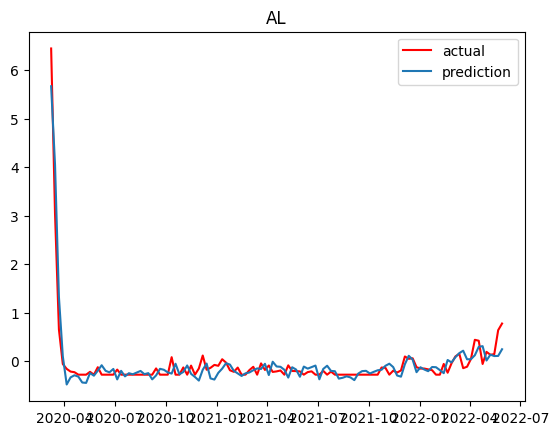

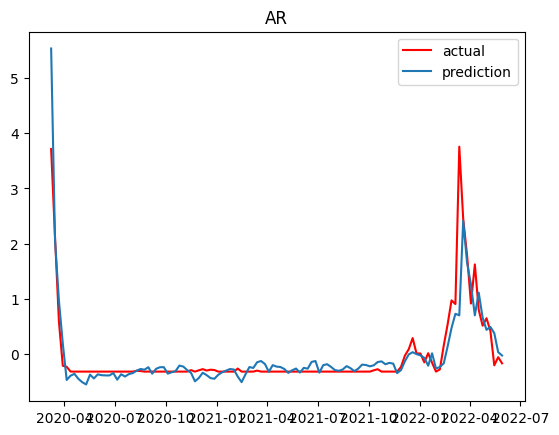

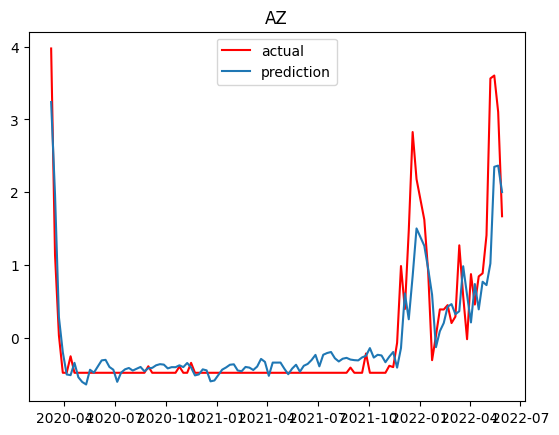

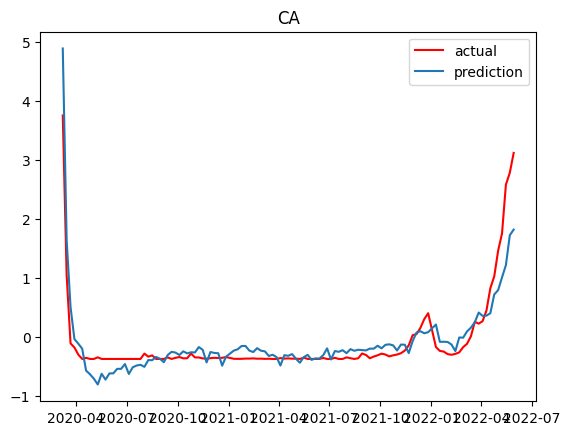

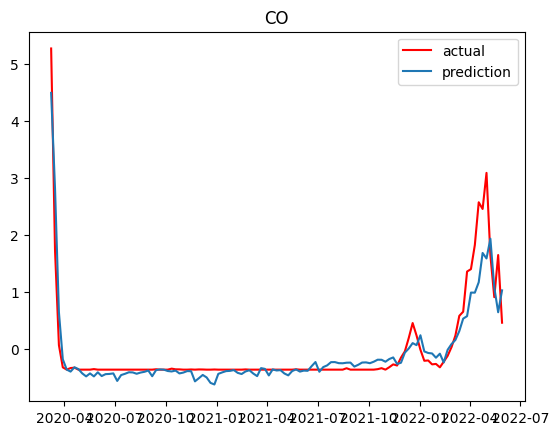

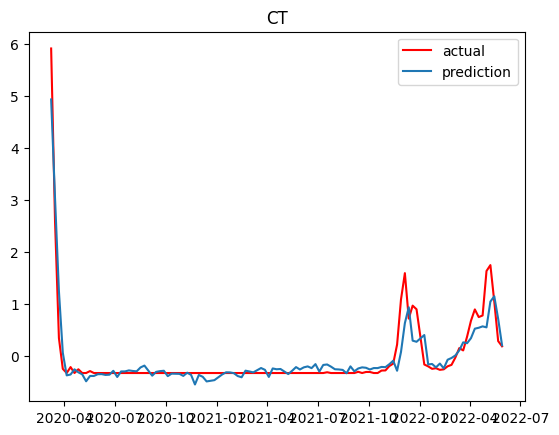

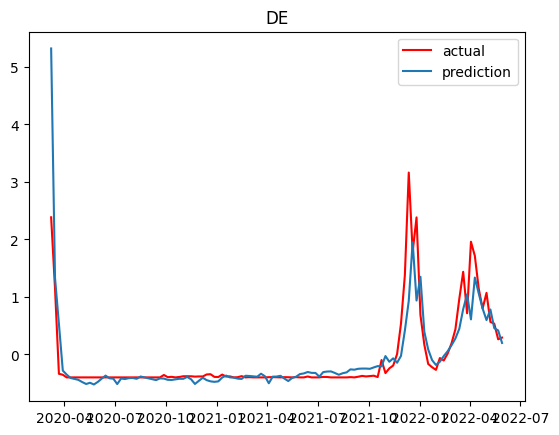

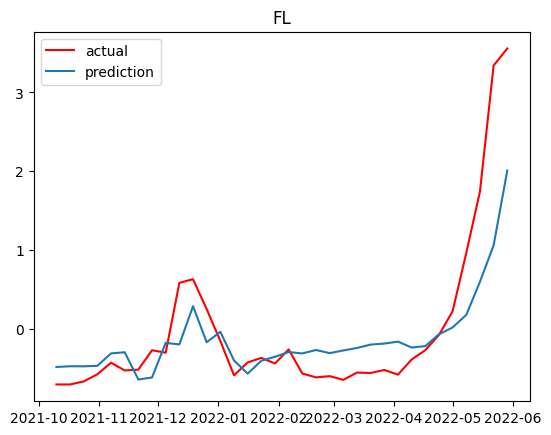

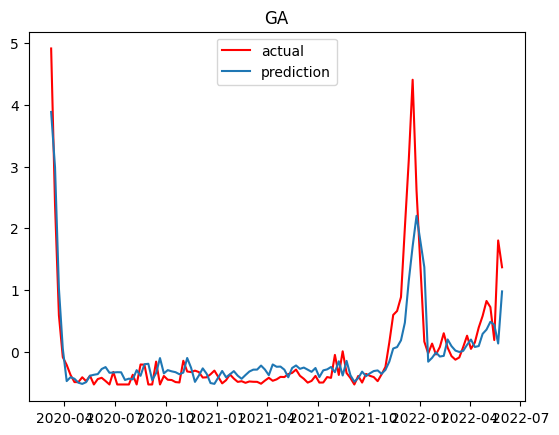

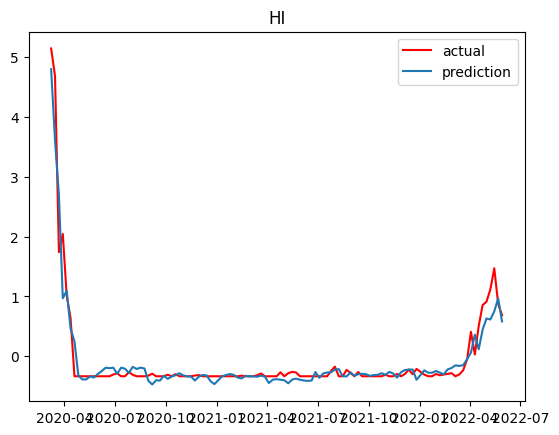

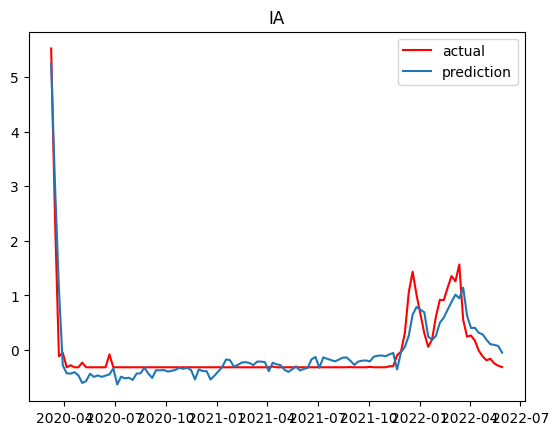

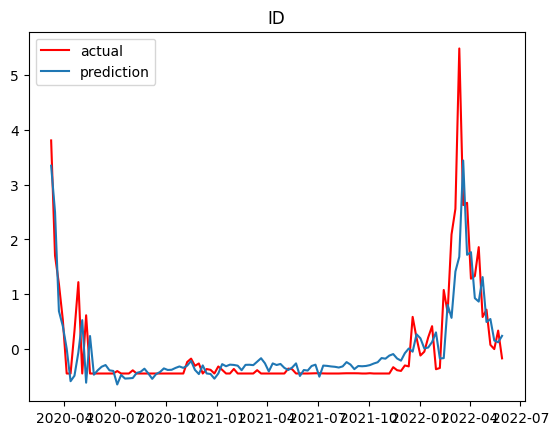

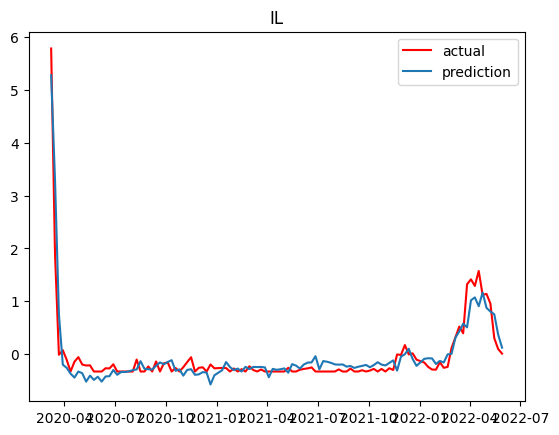

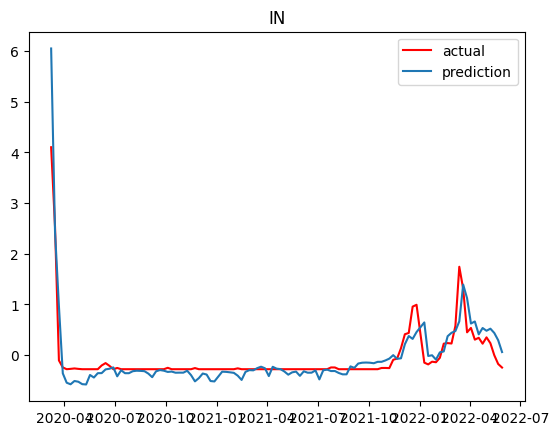

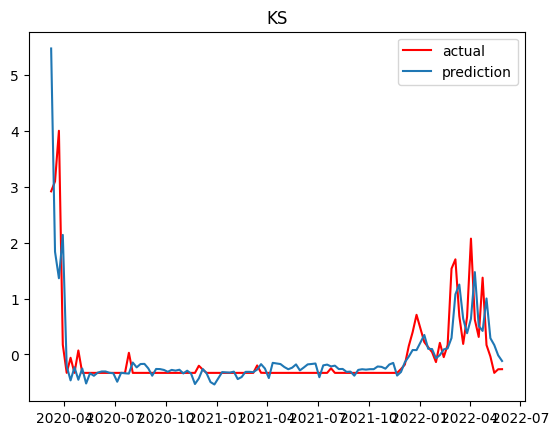

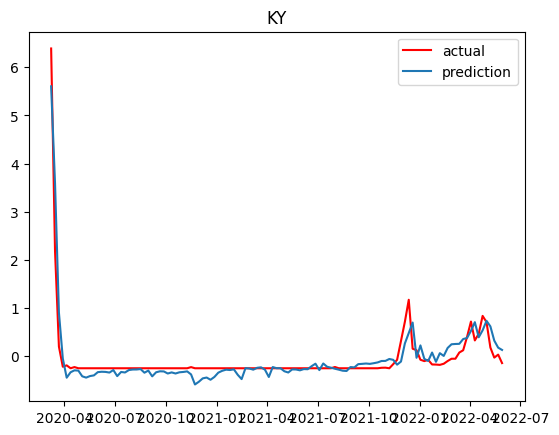

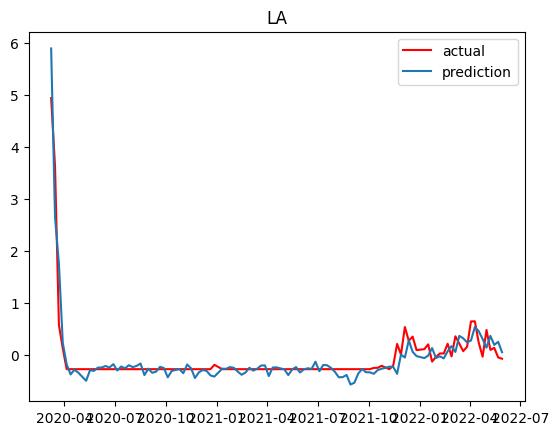

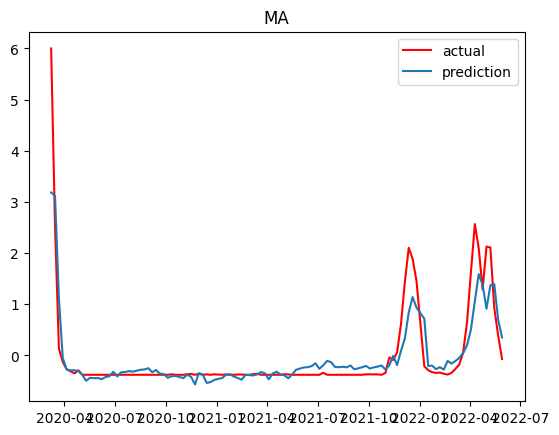

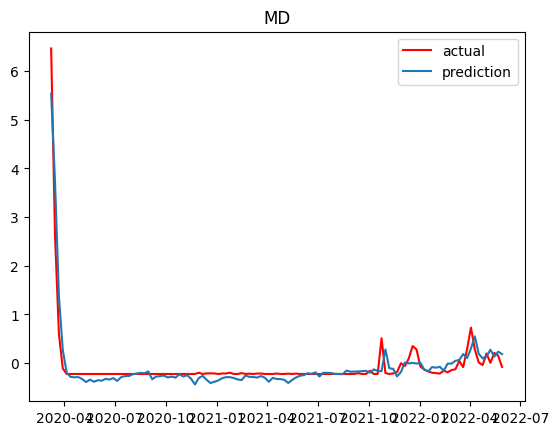

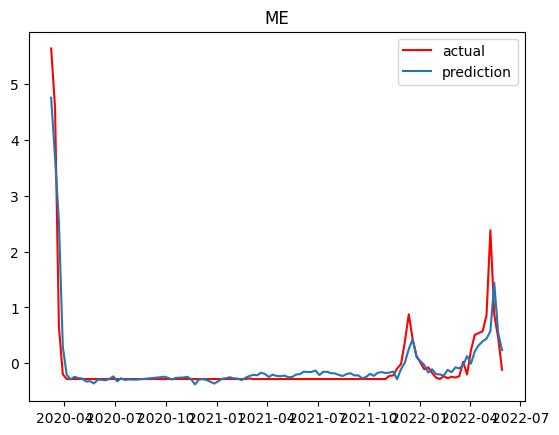

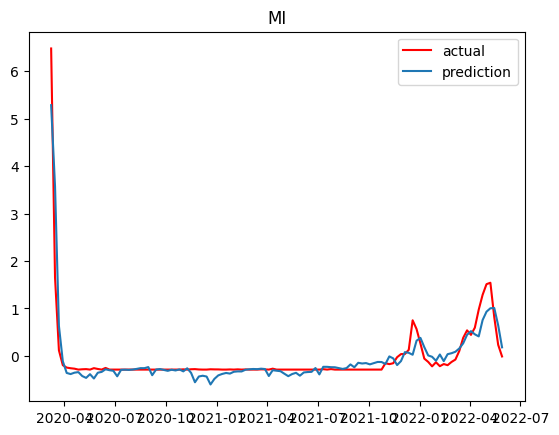

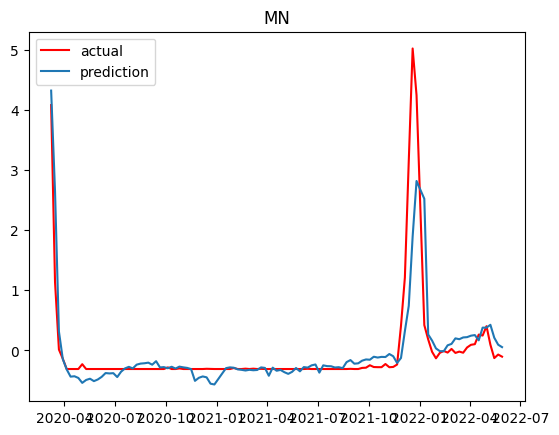

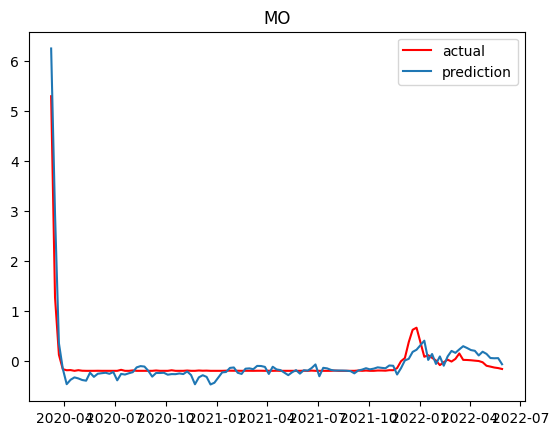

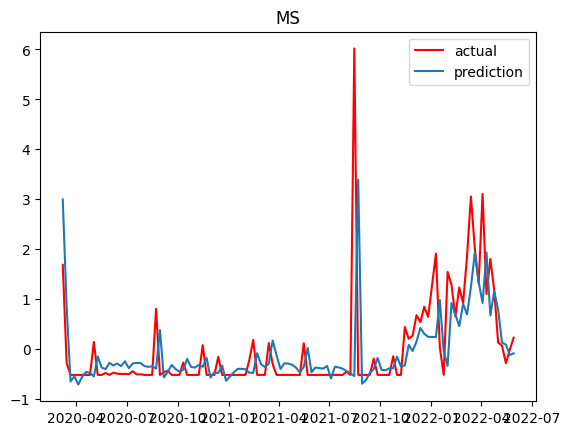

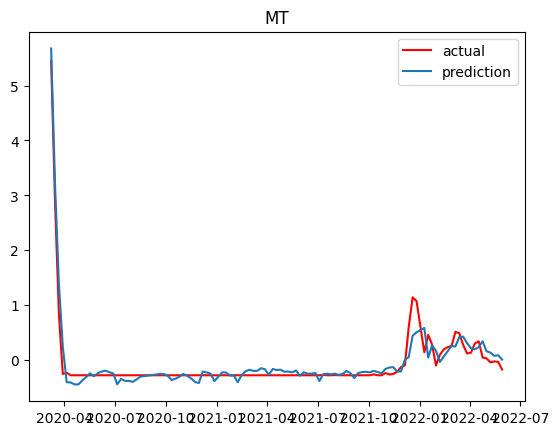

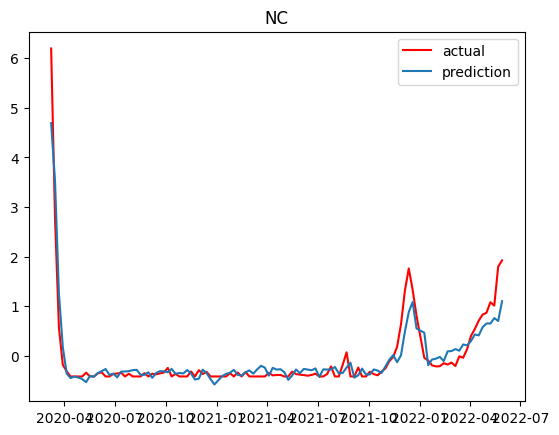

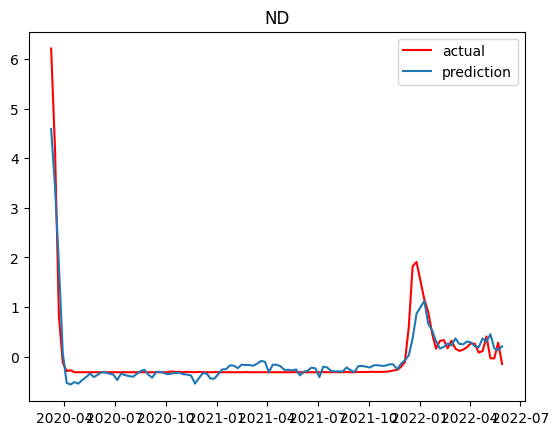

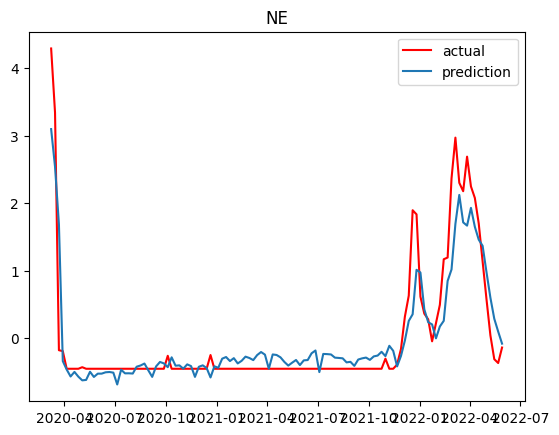

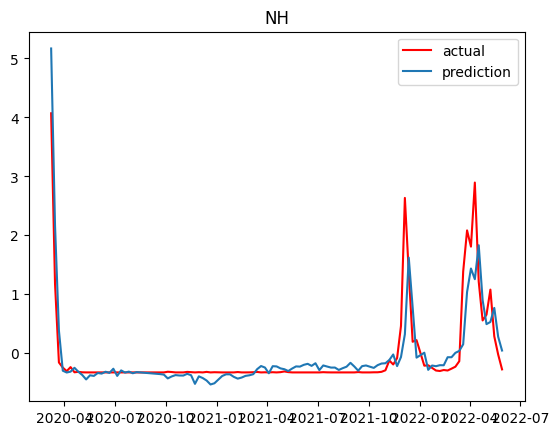

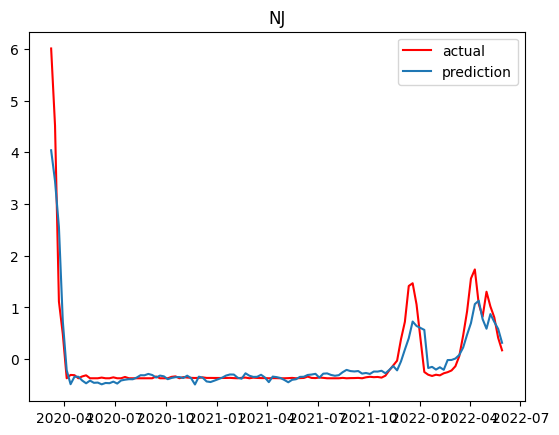

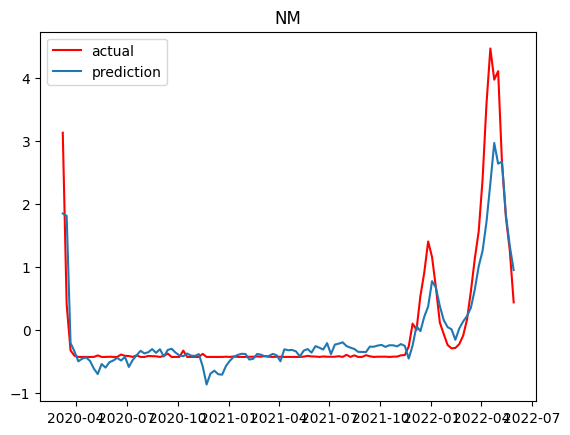

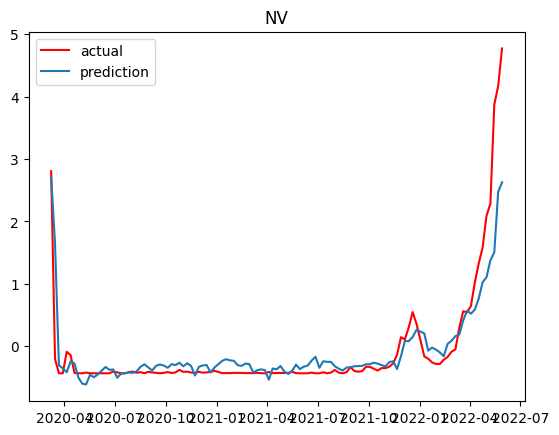

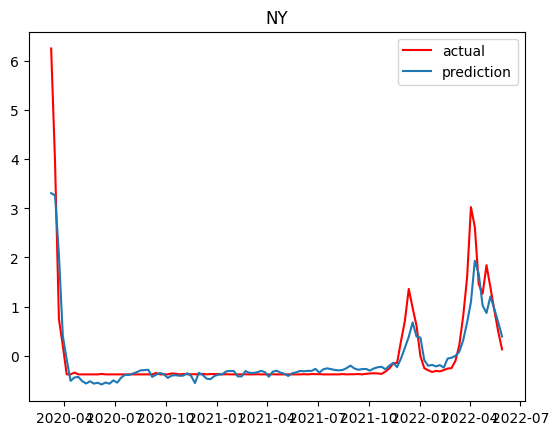

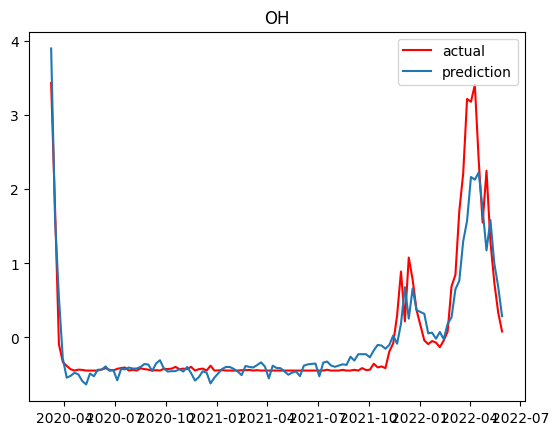

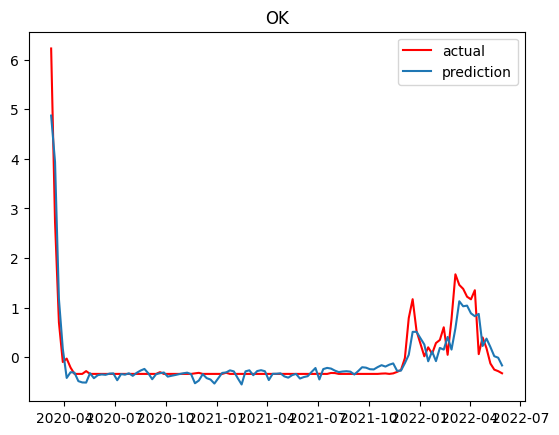

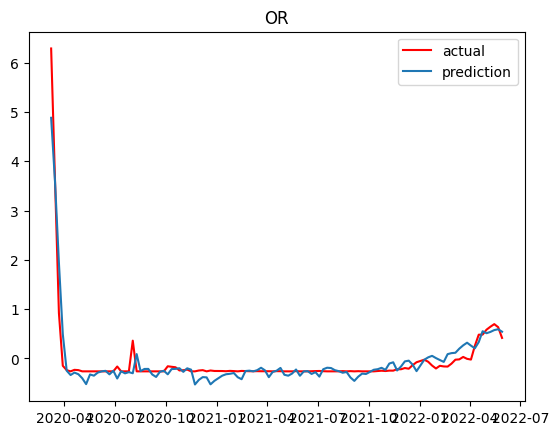

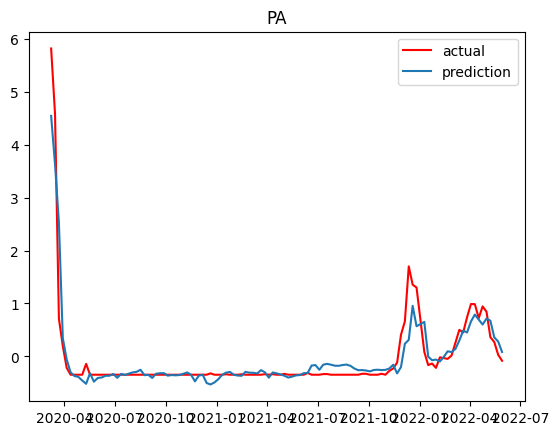

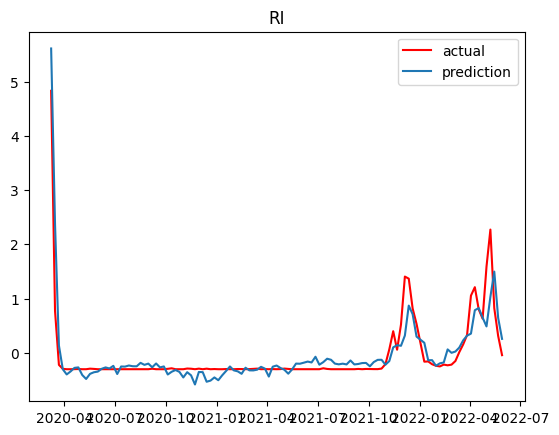

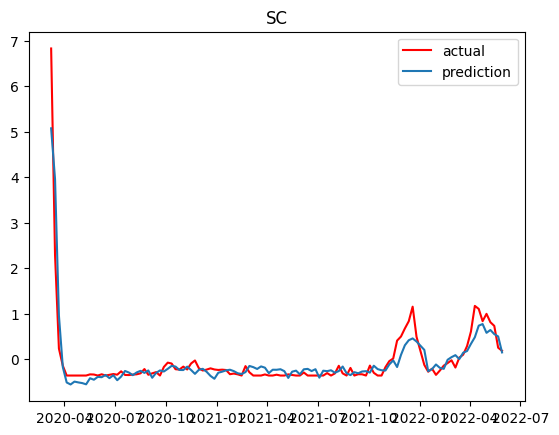

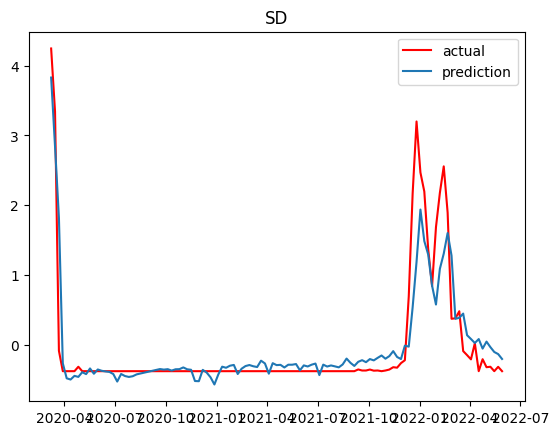

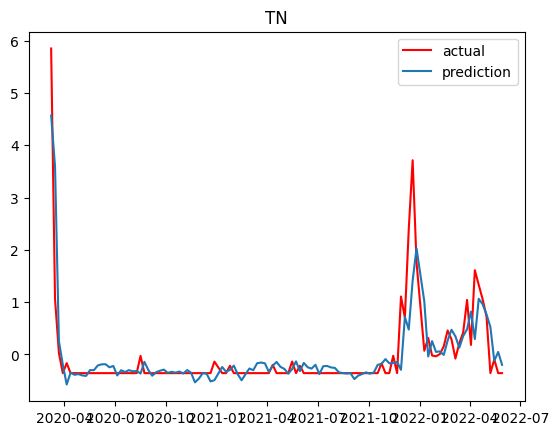

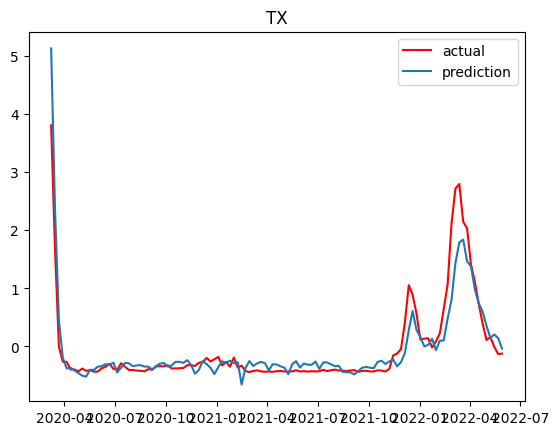

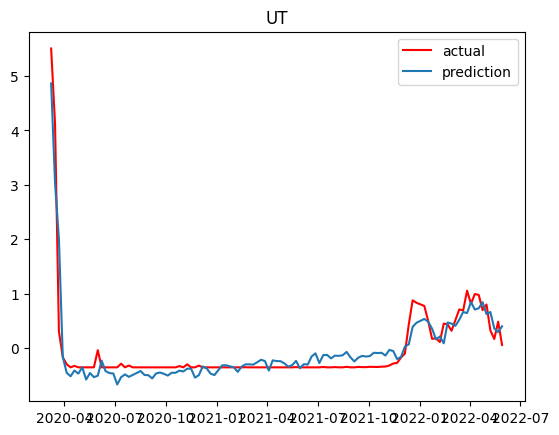

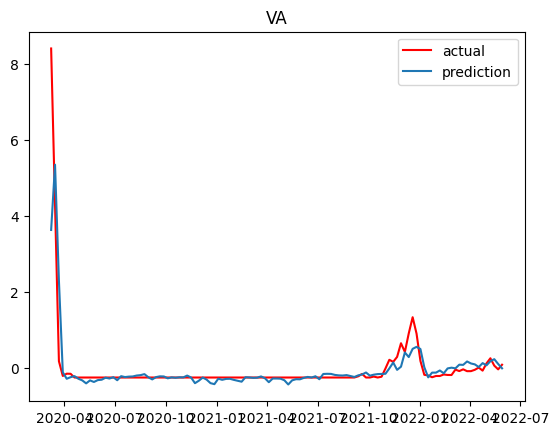

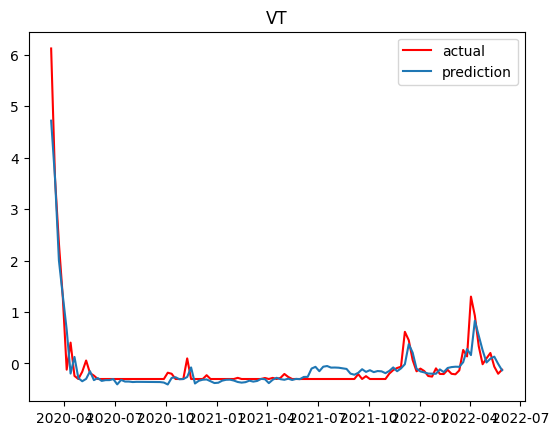

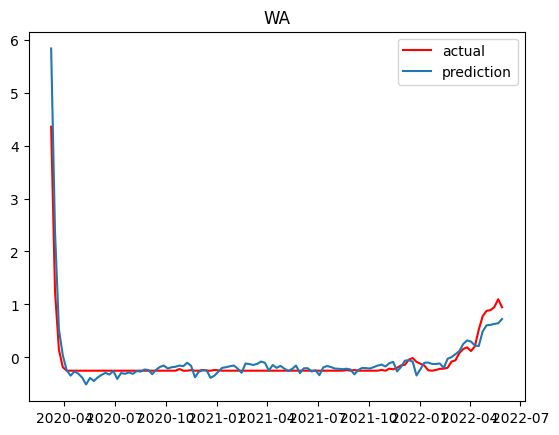

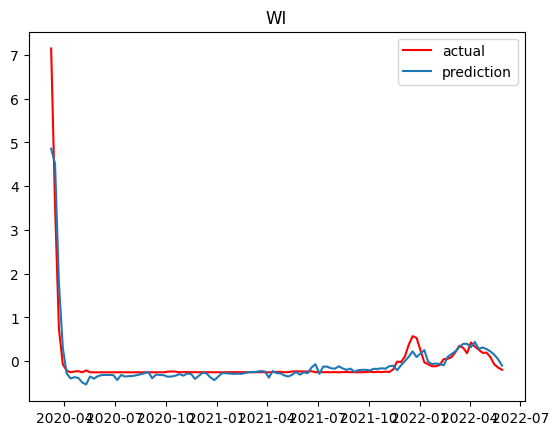

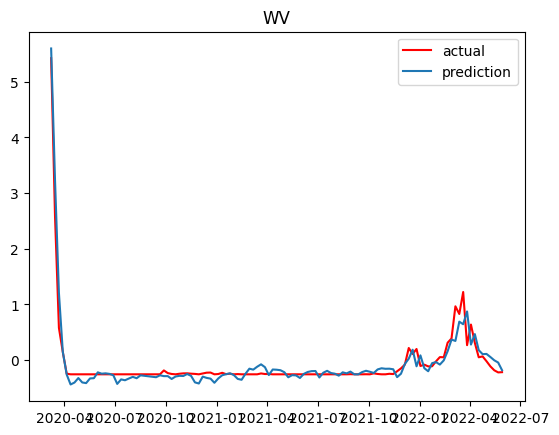

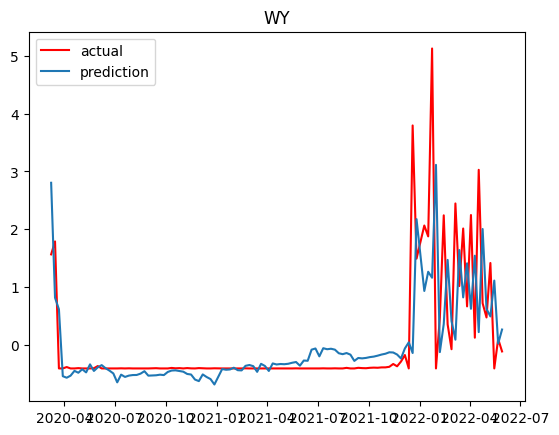

In [17]:
r2_scores = []

# Group your data by 'state' and get predictions and R-squared scores for each group
groups = combined_df1.groupby('state')
for group_name, group_data in groups:
    # Get predicted values for this group
    predicted_values_group = result.predict(group_data)
    
    # Calculate R-squared for this group
    actual_values_group = group_data['ILIp']
    r_squared_group = r2_score(actual_values_group, predicted_values_group)
    plt.plot(actual_values_group,color='red',label='actual')
    plt.plot(predicted_values_group,label='prediction')
    plt.legend()
    plt.title(group_name)
    plt.show()
    # Store the R-squared score in the list along with the group name
    r2_scores.append((group_name, r_squared_group))